# Zomato Data Analusis

In [ ]:
# %pip install geopy

In [1]:
# from google.colab import drive
# drive.mount('/content/MyDrive')

It looks like you want to analyze Zomato's delivery operations using these features. Are you looking for insights into delivery efficiency, customer satisfaction, or operational bottlenecks? Some possible areas of analysis could include:

* Delivery Time Analysis: How do factors like traffic, weather, and multiple deliveries impact delivery time?
* Driver Performance: How does driver age, ratings, and vehicle condition affect efficiency?
* Geospatial Analysis: How does restaurant and delivery location affect time taken?
* Festival Impact: Does delivery time increase during festivals?
* Order Type Influence: Do certain order types take longer to deliver?

Since you're working with a dataset on Zomato delivery operations, let's break it down into steps:

1. Data Cleaning
* Handle missing values in features like Delivery_person_Age, Delivery_person_Ratings, etc.
* Convert Order_Date, Time_Ordered, and Time_Order_picked into datetime format.
* Remove duplicates if any.
* Standardize categorical variables like Weather_conditions, Road_traffic_density, etc.

2. Exploratory Data Analysis (EDA)
* Summary statistics (describe(), info(), value_counts())
* Visualizations:
    * Distribution of Delivery Time (Time_taken (min))
    * Effect of Traffic Density on Delivery Time (sns.boxplot)
    * Impact of Weather on Delivery Time
    * Correlation between Age and Delivery Time
    * City-wise Delivery Performance

3. Feature Engineering
* Compute the distance between restaurant and delivery location using latitude/longitude.
* Extract hour and day of the week from Order_Date and Time_Ordered.
* Create a feature for peak hours (e.g., lunch/dinner rush).
* Encode categorical variables (OneHotEncoder or LabelEncoder).

4. Model Building (Optional)
* Predicting Delivery Time:
* Regression models (Linear Regression, Decision Tree, Random Forest, XGBoost)
* Feature selection and importance analysis
* Clustering of Delivery Locations (K-Means for optimization insights)

5. Insights & Recommendations
* How to optimize delivery times?
* What factors influence delays the most?
* How to allocate delivery resources efficiently?

Let's start with data cleaning and preprocessing using Python (Pandas & NumPy). 

A) Load the Dataset & Inspect


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import haversine as hs   
from haversine import Unit
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
import joblib

In [3]:


# Load dataset (update the file path)
raw_df = pd.read_csv(r"D:\DINESH_DATA_SCIENCE\MY_PROJECT\ZOMATO DATA ANALYSIS\Zomato Dataset.csv")

# Display basic info
print(raw_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45584 entries, 0 to 45583
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           45584 non-null  object 
 1   Delivery_person_ID           45584 non-null  object 
 2   Delivery_person_Age          43730 non-null  float64
 3   Delivery_person_Ratings      43676 non-null  float64
 4   Restaurant_latitude          45584 non-null  float64
 5   Restaurant_longitude         45584 non-null  float64
 6   Delivery_location_latitude   45584 non-null  float64
 7   Delivery_location_longitude  45584 non-null  float64
 8   Order_Date                   45584 non-null  object 
 9   Time_Orderd                  43853 non-null  object 
 10  Time_Order_picked            45584 non-null  object 
 11  Weather_conditions           44968 non-null  object 
 12  Road_traffic_density         44983 non-null  object 
 13  Vehicle_conditio

B) Eliminate Unecessary Features in Raw Data which does'nt effect the Target Variable.

- Here, the time taken(min) is the only target variable.

* Objective:
    - we are not picking the delivery person.
    - we are not paying the delivery person.
    - we are not pricing the food, based on Order_Date, city, festival or type of order. (i.e, with discounts)
    - we are only predicting the time taken to deliver the food order after it was picked in restaurant.

* According to our Objective we select the features and remove the rest of them.

00)   ID                          
        * we can use this food order ID as set_index for raw data.
01)   Delivery_person_ID          
        * Irrelavent feature for our objective.
02)   Delivery_person_Age         
        * Irrelavent feature for our objective.
03)   Delivery_person_Ratings     
        * we can use this as reference for driving skill of delivery person.
04)   Restaurant_latitude         
        * It can be used to measure the distance b/w restaurant and delivery location.
05)   Restaurant_longitude        
        * It can be used to measure the distance b/w restaurant and delivery location.
06)  Delivery_location_latitude
        * It can be used to measure the distance b/w restaurant and delivery location.
07)  Delivery_location_longitude 
        * It can be used to measure the distance b/w restaurant and delivery location.
08)   Order_Date                  
        * Irrelavent feature for our objective.
09)   Time_Orderd                 
        * Relavent feature but it affects on target variable are negligible.
10)  Time_Order_picked            
        * Relavent feature but it affects on target variable are negligible.
11)  Weather_conditions           
        * Based on Weather conditions we can determine the delay of delivery.
12)  Road_traffic_density         
        * Based on road traffic density we can determine the delay of delivery.
13)  Vehicle_condition            
        * Based on vehicle condition, we can determine the speed of delivery.
14)  Type_of_order                
        * Irrelavent feature for our objective.
15)  Type_of_vehicle              
        * Based on type of vehicle, we can determine the speed of delivery. 
16)  multiple_deliveries          
        * Based on availabilty of delivery person we determine the time taken.
17)  Festival                     
        * Irrelavent feature for our objective.
18)  City                         
        * Irrelavent feature for our objective.

*  Time_taken (min) ----> Target Variable.

In [4]:
# Drop unnecessary columns from the DataFrame
columns_to_drop = ['Delivery_person_ID', 
                   'Delivery_person_Age', 
                   'Order_Date', 
                   'Type_of_order', 
                   'Festival', 
                   'City',
                   'Time_Orderd', 
                   'Time_Order_picked']  # Replace with actual column names
raw_df = raw_df.drop(columns=columns_to_drop, axis=1)

# Verify the changes
print("Remaining columns:", raw_df.columns)

Remaining columns: Index(['ID', 'Delivery_person_Ratings', 'Restaurant_latitude',
       'Restaurant_longitude', 'Delivery_location_latitude',
       'Delivery_location_longitude', 'Weather_conditions',
       'Road_traffic_density', 'Vehicle_condition', 'Type_of_vehicle',
       'multiple_deliveries', 'Time_taken (min)'],
      dtype='object')


C) Measure the Distance between Restaurant and Delivery Location, Using the Haversine formula.

* To build the column Distance_Delivery_Location_Restaurant.
* After the Distance_Delivery_Location_Restaurant column is formed.
* Remove the columns we used to build Distance_Delivery_Location_Restaurant.
    
- The following columns needed to be eliminated are:
    * 'Restaurant_latitude' 
    * 'Restaurant_longitude'
    * 'Delivery_location_latitude' 
    * 'Delivery_location_longitude'



In [5]:
distance_delivery_location_restaurant = []

for i in range(len(raw_df['Delivery_location_latitude'])):
    loc1 = (raw_df['Delivery_location_latitude'][i], raw_df['Delivery_location_longitude'][i])
    loc2 = (raw_df['Restaurant_latitude'][i], raw_df['Restaurant_longitude'][i])
    result = hs.haversine(loc1, loc2, unit=Unit.KILOMETERS)

    distance_delivery_location_restaurant.append(round(result, 1))
    
print(len(distance_delivery_location_restaurant))
print(distance_delivery_location_restaurant)

45584
[10.3, 6.2, 13.8, 2.9, 19.4, 13.8, 6.2, 16.8, 10.8, 4.5, 12.3, 19.6, 1.6, 20.2, 6.1, 17.1, 4.5, 13.7, 14.0, 16.9, 4.7, 7.6, 7.7, 6.2, 17.3, 19.9, 10.7, 6.1, 1.5, 3.1, 3.1, 10.9, 10.9, 12.2, 13.7, 16.8, 3.0, 9.2, 9.3, 6.2, 1.5, 6.0, 17.1, 4.7, 12.5, 9.1, 14.0, 13.4, 12.6, 1.5, 9.4, 11.9, 4.7, 10.6, 16.8, 6.1, 3.0, 7.3, 3.1, 6.3, 14.0, 6.1, 6.1, 12.6, 3.1, 6.2, 9.2, 7.9, 14.0, 14.0, 6.1, 17.1, 17.3, 17.1, 16.8, 3.0, 9.2, 7.7, 6.2, 12.2, 1.6, 16.9, 1.5, 6048.6, 3.0, 13.4, 16.7, 7.8, 13.8, 7.8, 6.2, 16.9, 4.6, 19.9, 1.6, 3.0, 14.0, 16.8, 20.2, 3.0, 20.3, 16.7, 3.0, 12.2, 16.8, 7.8, 9.1, 1.6, 12.1, 13.6, 4.5, 16.7, 16.6, 6.2, 6.2, 7.5, 20.3, 16.6, 4.5, 12.4, 6.1, 1.5, 9.1, 3.1, 3.0, 14.0, 7.8, 6.3, 1.5, 14.0, 9.3, 4.6, 10.6, 17.1, 9.2, 12.2, 6.1, 4.7, 6.3, 10.7, 6.3, 9.3, 17.1, 3.1, 1.6, 6.2, 12.5, 20.2, 9.1, 17.1, 13.6, 12.1, 10.7, 7.6, 7.6, 11.0, 13.8, 14.0, 10.9, 12.1, 1.6, 4.7, 1.5, 9.4, 11.9, 10.5, 13.6, 7.7, 9.2, 6.2, 10.4, 9.3, 9.2, 10.9, 10.6, 12.1, 4.7, 3.0, 4.6, 14.0, 10.6, 

In [6]:
# Drop unnecessary columns from the DataFrame
columns_to_drop = ['Restaurant_latitude', 
                   'Restaurant_longitude', 
                   'Delivery_location_latitude', 
                   'Delivery_location_longitude']  # Replace with actual column names
raw_df = raw_df.drop(columns=columns_to_drop, axis=1)

# Verify the changes
print("Remaining columns:", raw_df.columns)

Remaining columns: Index(['ID', 'Delivery_person_Ratings', 'Weather_conditions',
       'Road_traffic_density', 'Vehicle_condition', 'Type_of_vehicle',
       'multiple_deliveries', 'Time_taken (min)'],
      dtype='object')


In [7]:
raw_df['Distance_Delivery_Location_Restaurant'] = distance_delivery_location_restaurant

D) Fill the Missing Data of Numerical & Categorical columns

In [8]:
# checking if any value is missing
print(raw_df.isnull().any(axis=0))

ID                                       False
Delivery_person_Ratings                   True
Weather_conditions                        True
Road_traffic_density                      True
Vehicle_condition                        False
Type_of_vehicle                          False
multiple_deliveries                       True
Time_taken (min)                         False
Distance_Delivery_Location_Restaurant    False
dtype: bool


In [9]:
value_types = raw_df['multiple_deliveries'].apply(type)
print(value_types.value_counts())

multiple_deliveries
<class 'float'>    45584
Name: count, dtype: int64


In [10]:
print(raw_df['multiple_deliveries'].unique())

[ 3.  1.  0. nan  2.]


* Let's Assume the 'nan' values in 'multiple_deliveries' column in raw data frame to be Zero.
* May be The Delivery person is free to deliver the current Order.

In [11]:
value_types = raw_df['Delivery_person_Ratings'].apply(type)
print(value_types.value_counts())

Delivery_person_Ratings
<class 'float'>    45584
Name: count, dtype: int64


In [12]:
print(raw_df['Delivery_person_Ratings'].unique())

[4.2 4.7 4.3 4.5 4.  4.9 4.1 5.  4.8 3.5 4.6 nan 4.4 3.8 3.9 3.7 2.6 2.5
 3.6 3.1 2.7 1.  3.2 3.3 6.  3.4 2.8 2.9 3. ]


* Let's Assume the 'nan' values in 'Delivery_person_Ratings' column in raw data frame to be Zero.
* May be The Delivery person is a freshmen and first to deliver the current Order.

In [13]:
# Fill missing values with a specific value, e.g., 0
columns_to_zero_fill = ['Delivery_person_Ratings', 'multiple_deliveries']
raw_df[columns_to_zero_fill] = raw_df[columns_to_zero_fill].fillna(0)

# Verify that there are no missing values in the specified columns
print(raw_df[columns_to_zero_fill].isnull().any())

Delivery_person_Ratings    False
multiple_deliveries        False
dtype: bool


In [14]:
# Distinguishing categorical columns
categorical_columns = raw_df.select_dtypes(include=['object'])
# checking if any value is missing in categorical columns
print(categorical_columns.isnull().any(axis=0))

ID                      False
Weather_conditions       True
Road_traffic_density     True
Type_of_vehicle         False
dtype: bool


* For now, we Should Focus on 'Weather_conditions' and 'Road_traffic_density' columns.

In [15]:
value_types = raw_df['Weather_conditions'].apply(type)
print(value_types.value_counts())

Weather_conditions
<class 'str'>      44968
<class 'float'>      616
Name: count, dtype: int64


In [16]:
print(raw_df['Weather_conditions'].unique())

['Fog' 'Stormy' 'Sandstorms' 'Windy' 'Cloudy' 'Sunny' nan]


In [17]:
# Fill missing values in the 'Weather_conditions' column using backward fill method
# raw_df['Weather_conditions'] = raw_df['Weather_conditions'].fillna(method='bfill')
raw_df['Weather_conditions'] = raw_df['Weather_conditions'].bfill()
# Verify that the missing values in 'Weather_conditions' have been filled.
print(raw_df['Weather_conditions'].isnull().any())

False


In [18]:
value_types = raw_df['Road_traffic_density'].apply(type)
print(value_types.value_counts())

Road_traffic_density
<class 'str'>      44983
<class 'float'>      601
Name: count, dtype: int64


In [19]:
print(raw_df['Road_traffic_density'].unique())

['Jam' 'High' 'Medium' 'Low' nan]


In [20]:
# Fill missing values in the 'Road_traffic_density' column using forward fill method
# raw_df['Road_traffic_density'] = raw_df['Road_traffic_density'].fillna(method='ffill')
raw_df['Road_traffic_density'] = raw_df['Road_traffic_density'].ffill()

# Verify that there are no missing values in the 'Road_traffic_density' column
print(raw_df['Road_traffic_density'].isnull().any())

False


In [21]:
value_types = raw_df['Weather_conditions'].apply(type)
print(value_types.value_counts())

Weather_conditions
<class 'str'>    45584
Name: count, dtype: int64


In [22]:
value_types = raw_df['Road_traffic_density'].apply(type)
print(value_types.value_counts())

Road_traffic_density
<class 'str'>    45584
Name: count, dtype: int64


In [23]:
print(list(categorical_columns))

['ID', 'Weather_conditions', 'Road_traffic_density', 'Type_of_vehicle']


E) Data Visualization (EDA) of target variable based on Catergorical Columns

I. Delivery Time Distribution

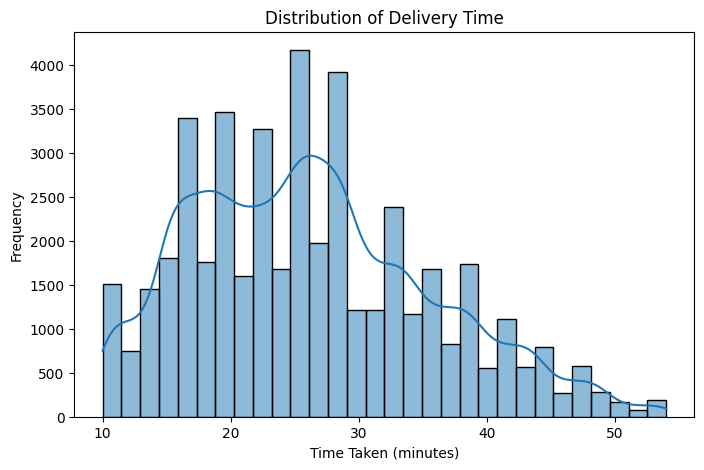

In [24]:
plt.figure(figsize=(8, 5))
sns.histplot(raw_df['Time_taken (min)'], bins=30, kde=True)
plt.title("Distribution of Delivery Time")
plt.xlabel("Time Taken (minutes)")
plt.ylabel("Frequency")
plt.show()

II. Impact of Traffic on Delivery Time

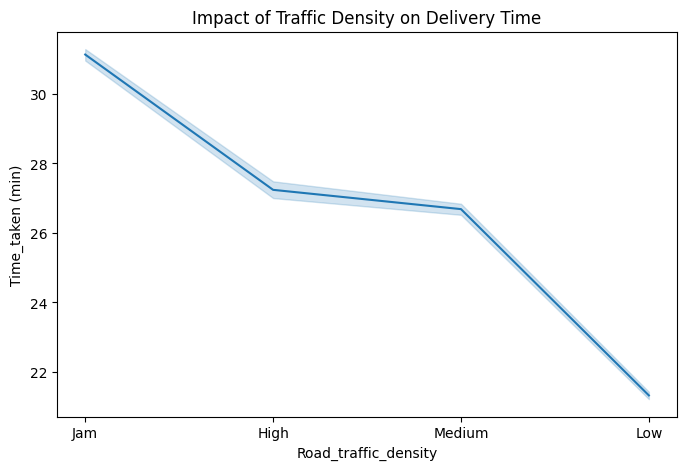

In [25]:
plt.figure(figsize=(8, 5))
sns.lineplot(x='Road_traffic_density', y='Time_taken (min)', data=raw_df)
plt.title("Impact of Traffic Density on Delivery Time")
plt.show()

III. Impact of Weather_conditions on Delivery Time

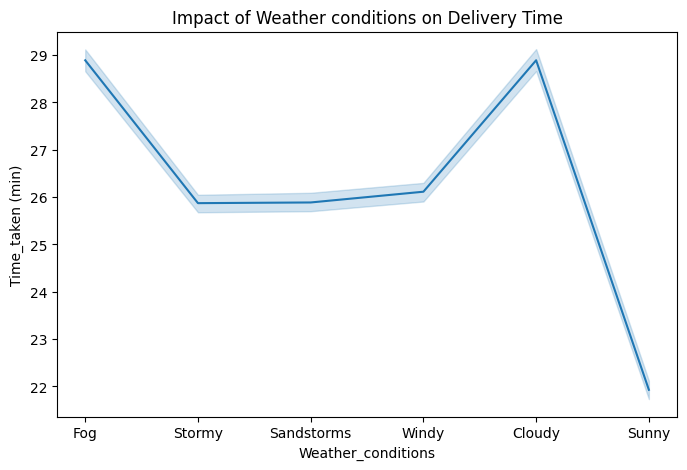

In [26]:
plt.figure(figsize=(8, 5))
sns.lineplot(x='Weather_conditions', y='Time_taken (min)', data=raw_df)
plt.title("Impact of Weather conditions on Delivery Time")
plt.show()

IV. Impact of Type_of_vehicle on Delivery Time

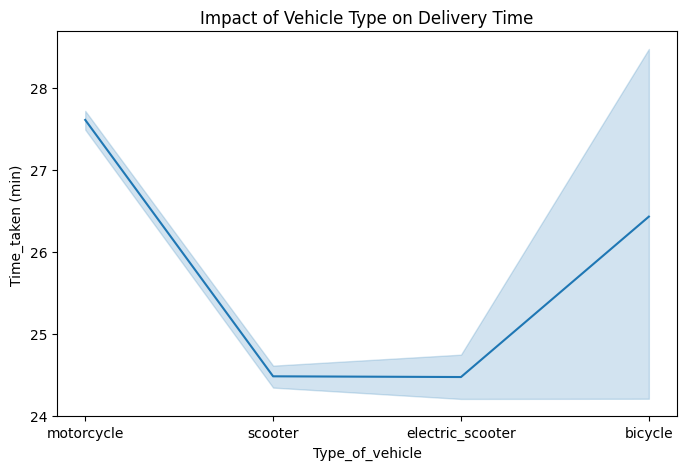

In [27]:
plt.figure(figsize=(8, 5))
sns.lineplot(x='Type_of_vehicle', y='Time_taken (min)', data=raw_df)
plt.title("Impact of Vehicle Type on Delivery Time")
plt.show()

In [28]:
# Distinguishing numerical columns
numerical_columns = raw_df.select_dtypes(include=['number'])
# checking if any value is missing in categorical columns
print(numerical_columns.isnull().any(axis=0))

Delivery_person_Ratings                  False
Vehicle_condition                        False
multiple_deliveries                      False
Time_taken (min)                         False
Distance_Delivery_Location_Restaurant    False
dtype: bool


F) Data Visualization (EDA) of target variable based on Numerical Columns

I. Delivery Time Distribution

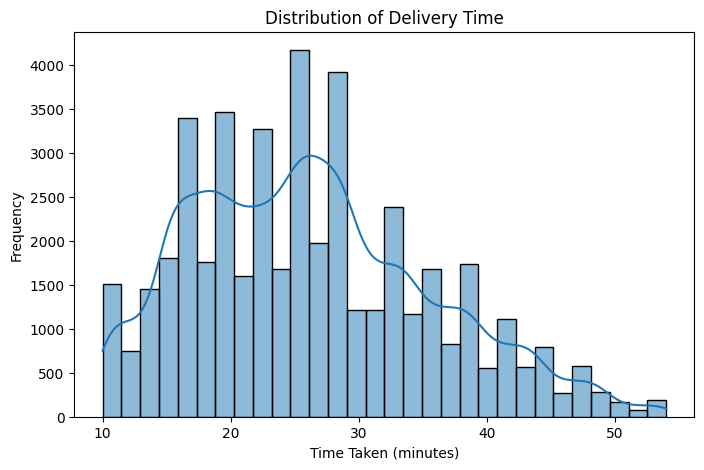

In [29]:

plt.figure(figsize=(8, 5))
sns.histplot(raw_df['Time_taken (min)'], bins=30, kde=True)
plt.title("Distribution of Delivery Time")
plt.xlabel("Time Taken (minutes)")
plt.ylabel("Frequency")
plt.show()

II. Impact of Delivery_person_Ratings on Delivery Time

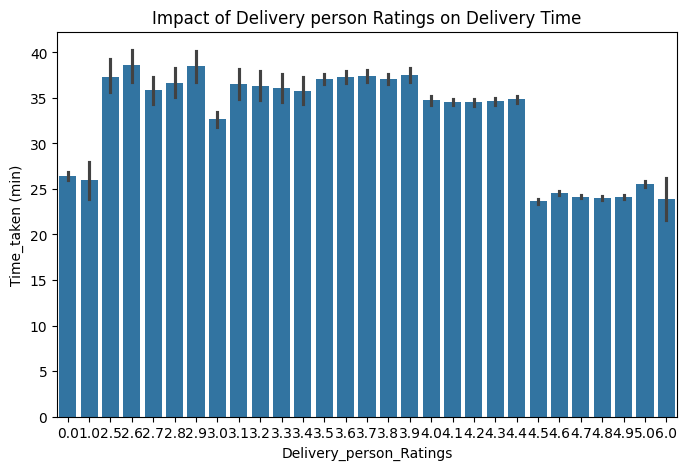

In [30]:
plt.figure(figsize=(8, 5))
sns.barplot(x='Delivery_person_Ratings', y='Time_taken (min)', data=raw_df)
plt.title("Impact of Delivery person Ratings on Delivery Time")
plt.show()

III. Impact of Vehicle_condition on Delivery Time

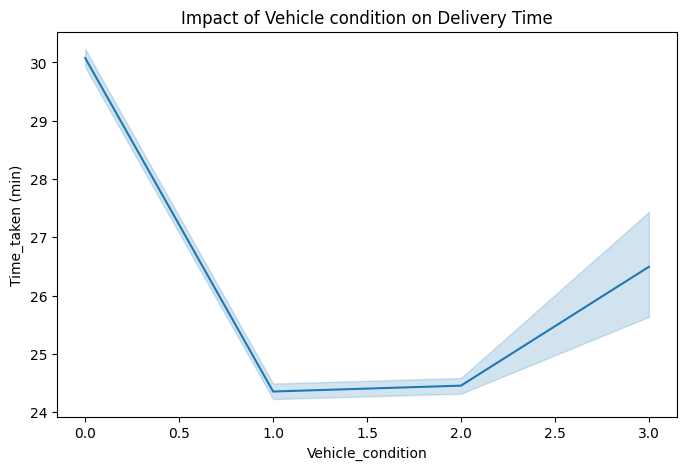

In [31]:
plt.figure(figsize=(8, 5))
sns.lineplot(x='Vehicle_condition', y='Time_taken (min)', data=raw_df)
plt.title("Impact of Vehicle condition on Delivery Time")
plt.show()

IV. Impact of multiple_deliveries on Delivery Time

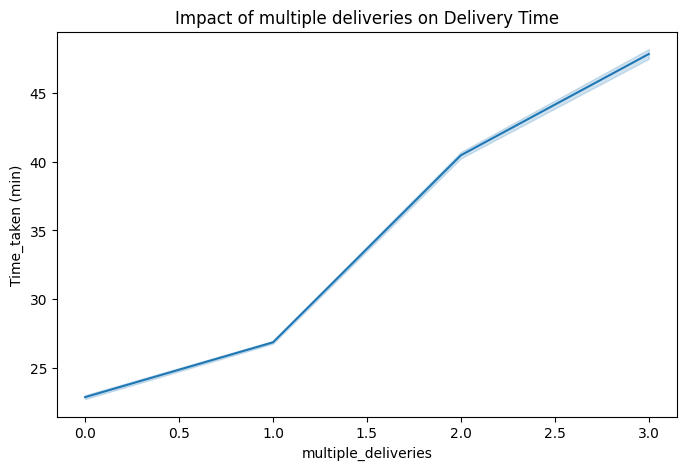

In [32]:
plt.figure(figsize=(8, 5))
sns.lineplot(x='multiple_deliveries', y='Time_taken (min)', data=raw_df)
plt.title("Impact of multiple deliveries on Delivery Time")
plt.show()

V. Impact of Distance_Delivery_Location_Restaurant on Delivery Time

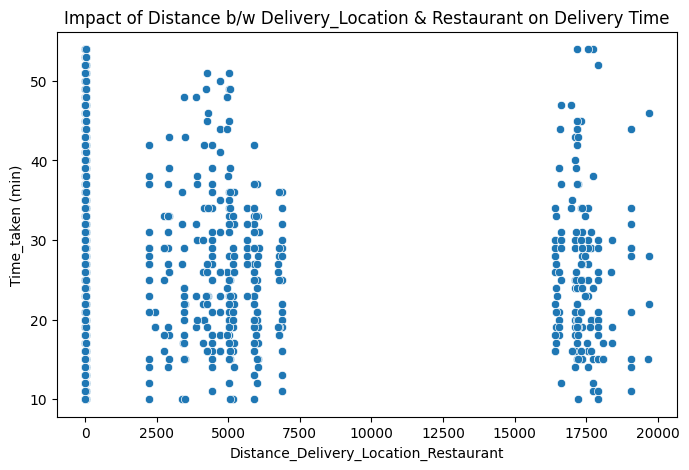

In [33]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x='Distance_Delivery_Location_Restaurant', y='Time_taken (min)', data=raw_df)
plt.title("Impact of Distance b/w Delivery_Location & Restaurant on Delivery Time")
plt.show()

In [34]:
# Check for missing values
print(raw_df.isnull().sum())

ID                                       0
Delivery_person_Ratings                  0
Weather_conditions                       0
Road_traffic_density                     0
Vehicle_condition                        0
Type_of_vehicle                          0
multiple_deliveries                      0
Time_taken (min)                         0
Distance_Delivery_Location_Restaurant    0
dtype: int64


In [35]:
# View first 5 rows
raw_df.head()

,ID,Delivery_person_Ratings,Weather_conditions,Road_traffic_density,Vehicle_condition,Type_of_vehicle,multiple_deliveries,Time_taken (min),Distance_Delivery_Location_Restaurant
0,0xcdcd,4.2,Fog,Jam,2,motorcycle,3.0,46,10.3
1,0xd987,4.7,Stormy,High,1,motorcycle,1.0,23,6.2
2,0x2784,4.7,Sandstorms,Medium,1,scooter,1.0,21,13.8
3,0xc8b6,4.3,Sandstorms,Low,0,motorcycle,0.0,20,2.9
4,0xdb64,4.7,Fog,Jam,1,scooter,1.0,41,19.4


In [36]:
# View last 5 rows
raw_df.tail()

,ID,Delivery_person_Ratings,Weather_conditions,Road_traffic_density,Vehicle_condition,Type_of_vehicle,multiple_deliveries,Time_taken (min),Distance_Delivery_Location_Restaurant
45579,0x7c09,4.8,Windy,High,1,motorcycle,0.0,32,1.5
45580,0xd641,4.6,Windy,Jam,0,motorcycle,1.0,36,11.0
45581,0x4f8d,4.9,Cloudy,Low,1,scooter,0.0,16,4.7
45582,0x5eee,4.7,Cloudy,High,0,motorcycle,1.0,26,6.2
45583,0x5fb2,4.9,Fog,Medium,2,scooter,1.0,36,12.1


In [37]:
# save the cleaned DataFrame to an Excel file
raw_df.to_excel(r'D:\DINESH_DATA_SCIENCE\MY_PROJECT\ZOMATO DATA ANALYSIS\cleaned_zomato_dataset.xlsx', index=False)

In [38]:
# load the cleaned DataFrame from the Excel file
df = pd.read_excel(r'D:\DINESH_DATA_SCIENCE\MY_PROJECT\ZOMATO DATA ANALYSIS\cleaned_zomato_dataset.xlsx')

G) Encode Categorical Variables

In [39]:
# Encode categorical variables
label_encoders = {}
categorical_cols = ['Weather_conditions', 'Road_traffic_density', 'Type_of_vehicle']

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Save encoders for later use

H) Feature Selection & Model Building
* Now, let's build a machine learning model to predict Time_taken (min) using regression techniques.

1) Select Features & Split Data

In [40]:

# Define feature columns and target variable
features = ['Delivery_person_Ratings', 
            'Weather_conditions', 
            'Road_traffic_density', 
            'Vehicle_condition', 
            'Type_of_vehicle', 
            'multiple_deliveries',
            'Distance_Delivery_Location_Restaurant']

X = df[features]  # Feature matrix
y = df['Time_taken (min)']  # Target variable

# Split into train and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


2) Train Regression Models

* Linear Regression

In [41]:

# Train model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predictions
y_pred = lr_model.predict(X_test)

# Model Evaluation
print("Linear Regression Performance:")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.2f}")
print(f"R² Score: {r2_score(y_test, y_pred):.2f}")


Linear Regression Performance:
MAE: 6.63
MSE: 66.07
R² Score: 0.25


* Random Forest Regression (Better for Non-Linear Data)

In [42]:

# Train model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=13)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)

# Model Evaluation
print("Random Forest Performance:")
print(f"MAE: {mean_absolute_error(y_test, y_pred_rf):.2f}")
print(f"MSE: {mean_squared_error(y_test, y_pred_rf):.2f}")
print(f"R² Score: {r2_score(y_test, y_pred_rf):.2f}")


Random Forest Performance:
MAE: 4.04
MSE: 26.64
R² Score: 0.70


* Feature Importance (For Tree-Based Models)

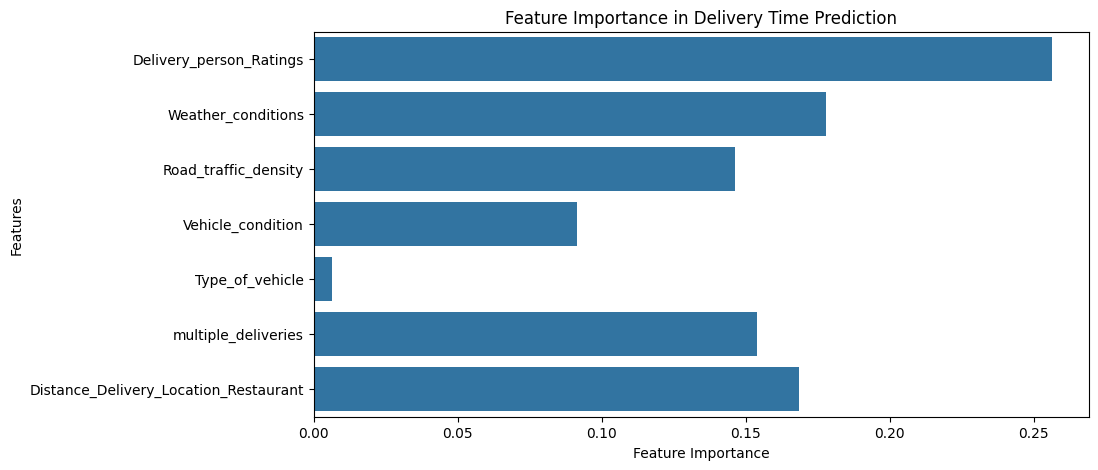

In [43]:
importances = rf_model.feature_importances_
feature_names = X.columns

# Plot Feature Importance
plt.figure(figsize=(10, 5))
sns.barplot(x=importances, y=feature_names)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance in Delivery Time Prediction")
plt.show()

* Gradient Boosting (More Advanced Model)

In [44]:

# Train model
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gb_model.fit(X_train, y_train)

# Predictions
y_pred_gb = gb_model.predict(X_test)

# Model Evaluation
print("Gradient Boosting Performance:")
print(f"MAE: {mean_absolute_error(y_test, y_pred_gb):.2f}")
print(f"MSE: {mean_squared_error(y_test, y_pred_gb):.2f}")
print(f"R² Score: {r2_score(y_test, y_pred_gb):.2f}")


Gradient Boosting Performance:
MAE: 4.29
MSE: 29.46
R² Score: 0.67


* Next Steps
    * Compare Models: Identify the best-performing model based on R² score, MAE, and MSE.

    * Hyperparameter Tuning: Use GridSearchCV to fine-tune the best model.

    * Deploy Model: If required, I can help with saving & deploying the model using Flask or FastAPI.

3) Hyperparameter Tuning & Model Deployment

* Since Random Forest and Gradient Boosting are more effective for non-linear data.
* let’s optimize them using GridSearchCV. 
* Hyperparameter Tuning using GridSearchCV.

In [45]:
# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees
    'max_depth': [10, 20, None],  # Depth of trees
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split
    'min_samples_leaf': [1, 2, 4]  # Minimum samples at a leaf node
}

# Initialize model
rf = RandomForestRegressor(random_state=42)

# Grid Search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2, scoring='r2')

# Fit GridSearch
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Train final model with best parameters
best_rf = grid_search.best_estimator_

# Predict
y_pred_best = best_rf.predict(X_test)

# Evaluate final tuned model
print("Tuned Random Forest Performance:")
print(f"MAE: {mean_absolute_error(y_test, y_pred_best):.2f}")
print(f"MSE: {mean_squared_error(y_test, y_pred_best):.2f}")
print(f"R² Score: {r2_score(y_test, y_pred_best):.2f}")

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
Tuned Random Forest Performance:
MAE: 3.99
MSE: 25.76
R² Score: 0.71


4) Save & Deploy the Model
* Once we have the best model, let’s save it using joblib and deploy it with Flask.
* Save the Model

In [ ]:
# Save the trained model
joblib.dump(best_rf, "delivery_time_predictor.pkl")
print("Model saved successfully!")


Model saved successfully!
